In [1]:
import numpy as np
import matplotlib.pyplot as plt
from helper_functions import *
from sampling.sghmc_sampling import *
from sampling.em_optimiser import *
from models.hd_regression_model import HDRegressionModel
from models.ld_regression_model import LDRegressionModel

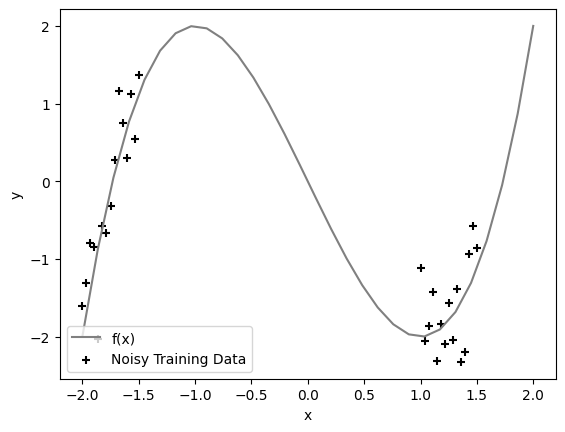

In [2]:
# training data generation
sigma = 0.5
f = lambda x : x**3 - 3*x
x_test = np.linspace(-2, 2, 30)
y_test = f(x_test)
x_train = np.concatenate((np.linspace(-2, -1.5, 15), np.linspace(1,1.5,15)))
y_train = f(x_train) + np.random.normal(0, sigma, len(x_train))
fig, ax = plt.subplots()
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.scatter(x_train, y_train, marker='+', color='Black', label='Noisy Training Data')
ax.plot(x_test, y_test, color='Grey', label='f(x)')
ax.legend(loc='lower left')
plt.show()

# dimensions of output from basis function
d_dash = 4

# phi function for LR
def phi(x):
	return np.array([1, x, x**2, x**3], dtype=object)

In [3]:
b = 1/sigma**2
var_prior = 3
A = np.linalg.inv(np.diag(np.full(d_dash, var_prior)))
model = HDRegressionModel(x_train, y_train, np.full(len(x_train), b), A, phi)
ld_model = LDRegressionModel(x_train, y_train, np.full(len(x_train), b), A, phi)
sampler = SGHMCsampler(model, 30, 0.01, np.zeros(4), 100, ld_model.mean, Minv=np.diag(np.full(d_dash, 1)))
em_optimiser = EMOptimiser(sampler)

In [4]:
means, samples = em_optimiser.sample(100, max_iters=10)

100%|██████████| 10/10 [00:03<00:00,  2.86it/s]


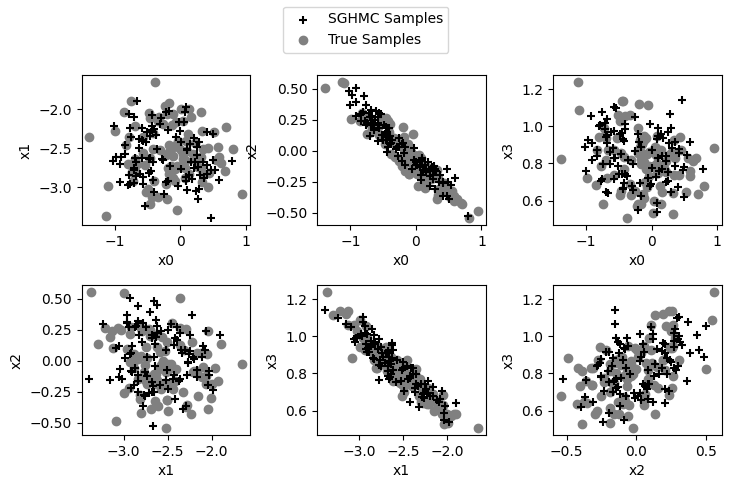

In [5]:
test_samples = np.random.multivariate_normal(ld_model.mean, ld_model.Hinv, size=100)
fig, ax = plt.subplots(2,3)
for i in range(4):
    for j in range(i,4):
        if i != j:       
            if i == 0:
                ax[i][j-1].scatter(samples[:,i], samples[:,j], color='Black', marker='+', label="SGHMC Samples")
                ax[i][j-1].scatter(test_samples[:,i], test_samples[:,j], c='Grey', zorder=-1, label="True Samples")
                ax[i][j-1].set_xlabel("x{}".format(i))
                ax[i][j-1].set_ylabel("x{}".format(j))
            else:
                ax[1][i+j-3].scatter(samples[:,i], samples[:,j], color='Black', marker='+',label="SGHMC Samples")
                ax[1][i+j-3].scatter(test_samples[:,i], test_samples[:,j], c='Grey', zorder=-1, label="True Samples")
                ax[1][i+j-3].set_xlabel("x{}".format(i))
                ax[1][i+j-3].set_ylabel("x{}".format(j))
handles, labels = ax[1][2].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center')
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=1.1,
                    top=0.85,
                    wspace=0.4,
                    hspace=0.4)

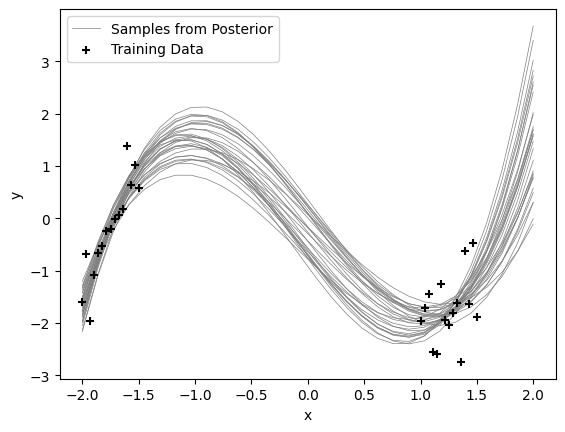

In [6]:
fig, ax = plt.subplots()
ax.plot(x_test, samples[0] @ phi(x_test), color='Grey', linewidth=0.5, label='Samples from Posterior')
for s in samples[1:30]:
	ax.plot(x_test, s @ phi(x_test), color='Grey', linewidth=0.5)
ax.scatter(x_train, y_train, marker='+', color='Black', zorder=100, label='Training Data')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.legend(loc='upper left')